In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [3]:
IMG_SIZE   = 224
BATCH_SIZE = 64

DATA_DIR = "/kaggle/input/teeth-dataset-0/Teeth_Dataset"
train_dir = os.path.join(DATA_DIR, "Training")
val_dir   = os.path.join(DATA_DIR, "Validation")

CLASSES = sorted(os.listdir(train_dir))
print(f"Classes ({len(CLASSES)}): {CLASSES}")

Classes (7): ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.95, 1.05],
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255          
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


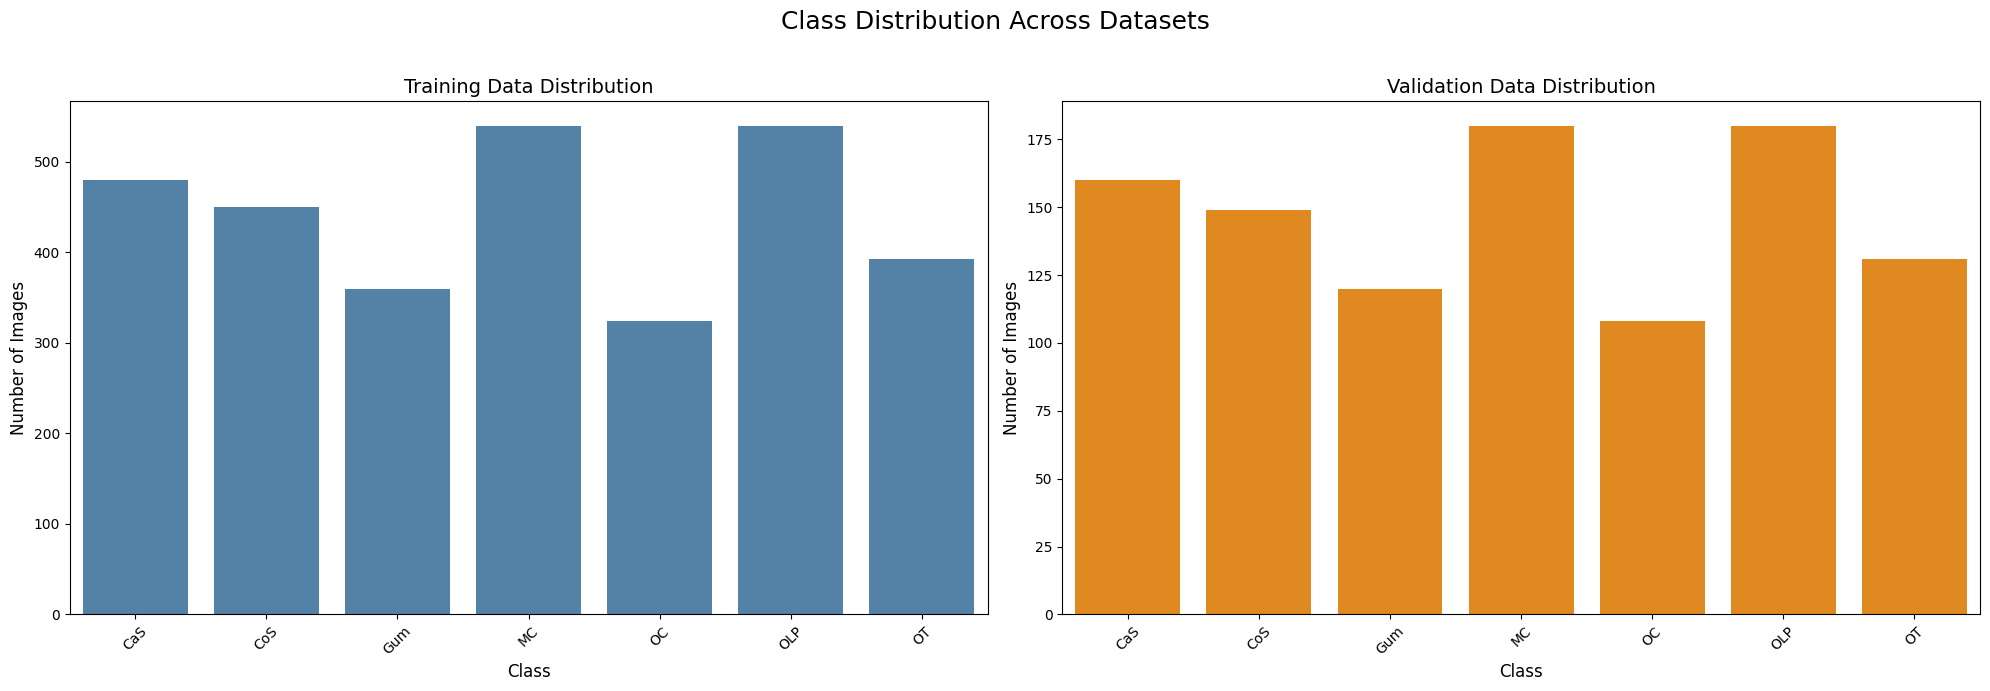

In [15]:
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Class Distribution Across Datasets', fontsize=18)

train_labels = train_generator.classes
train_class_names = list(train_generator.class_indices.keys())
train_class_counts = pd.Series(train_labels).value_counts().sort_index()
train_class_counts.index = [train_class_names[i] for i in train_class_counts.index]


sns.barplot(x=train_class_counts.index, y=train_class_counts.values, ax=axs[0], color='steelblue') 
axs[0].set_title('Training Data Distribution', fontsize=14)
axs[0].set_xlabel('Class', fontsize=12)
axs[0].set_ylabel('Number of Images', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)


val_labels = val_generator.classes
val_class_names = list(val_generator.class_indices.keys())
val_class_counts = pd.Series(val_labels).value_counts().sort_index()
val_class_counts.index = [val_class_names[i] for i in val_class_counts.index]


sns.barplot(x=val_class_counts.index, y=val_class_counts.values, ax=axs[1], color='darkorange')
axs[1].set_title('Validation Data Distribution', fontsize=14)
axs[1].set_xlabel('Class', fontsize=12)
axs[1].set_ylabel('Number of Images', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

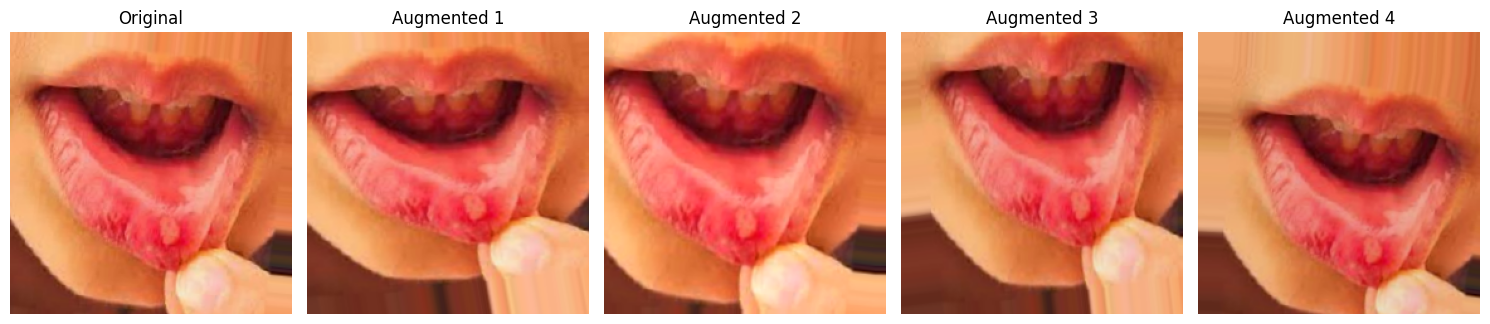

In [5]:
x_batch, y_batch = next(train_generator)
original_image = x_batch[0]                      

img_uint8 = (original_image * 255).astype(np.uint8)
img_array = np.expand_dims(img_uint8, axis=0)


manual_aug = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.95, 1.05],
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
for i, batch in enumerate(manual_aug.flow(img_array, batch_size=1)):
    augmented_images.append(batch[0].astype(np.uint8))
    if i >= 3:       
        break


plt.figure(figsize=(15, 4))
plt.subplot(1, 5, 1); plt.imshow(img_uint8);           plt.title('Original');      plt.axis('off')
for i in range(4):
    plt.subplot(1, 5, i + 2); plt.imshow(augmented_images[i])
    plt.title(f'Augmented {i+1}'); plt.axis('off')
plt.tight_layout(); plt.show()


In [6]:
def preprocess_image_show(img_rgb, img_size=224):
    steps = {}

    # 1. Original
    steps['Original'] = img_rgb.copy()
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    # 2. Resize
    img_resized = cv2.resize(img_bgr, (img_size, img_size), interpolation=cv2.INTER_AREA)
    steps['Resized'] = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 3. Denoising
    img_denoised = cv2.fastNlMeansDenoisingColored(img_resized, None, 10, 10, 7, 21)
    steps['Denoised'] = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2RGB)

    # 4. Histogram Equalization
    img_yuv = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    steps['Equalized'] = img_equalized.copy()

    # 5. Normalization
    img_normalized = (img_equalized.astype('float32') / 255.0)
    steps['Normalized'] = (img_normalized * 255).astype(np.uint8)

    return steps


In [7]:
all_images = [img_uint8] + augmented_images
titles      = ['Original'] + [f'Augmented {i+1}' for i in range(4)]


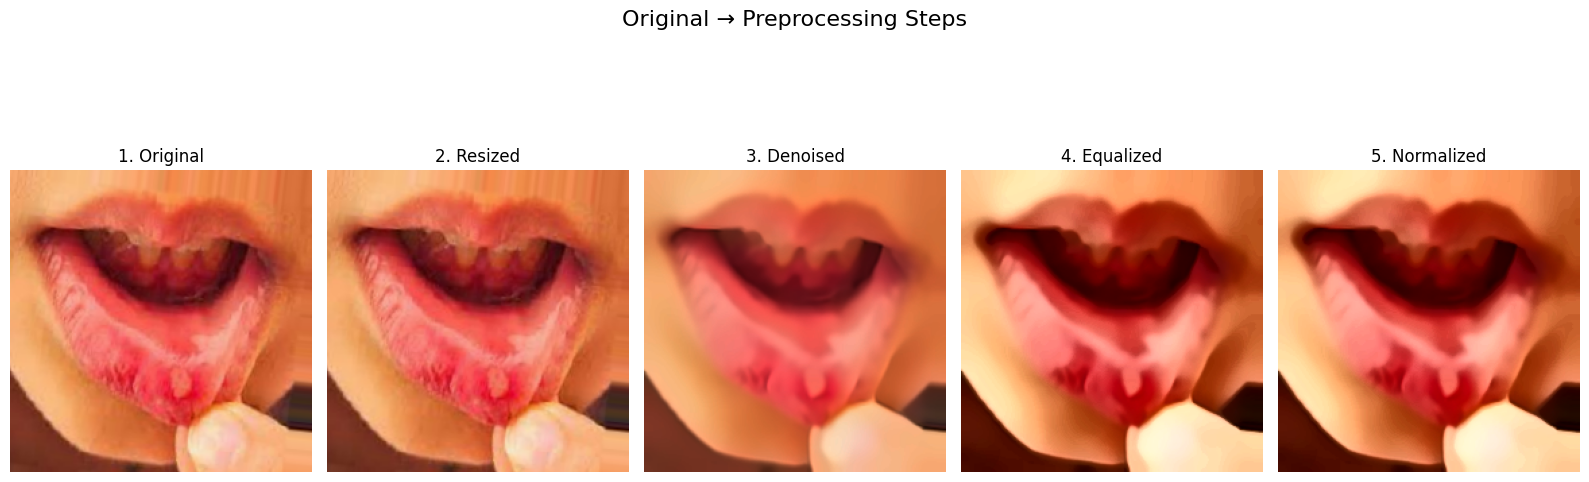

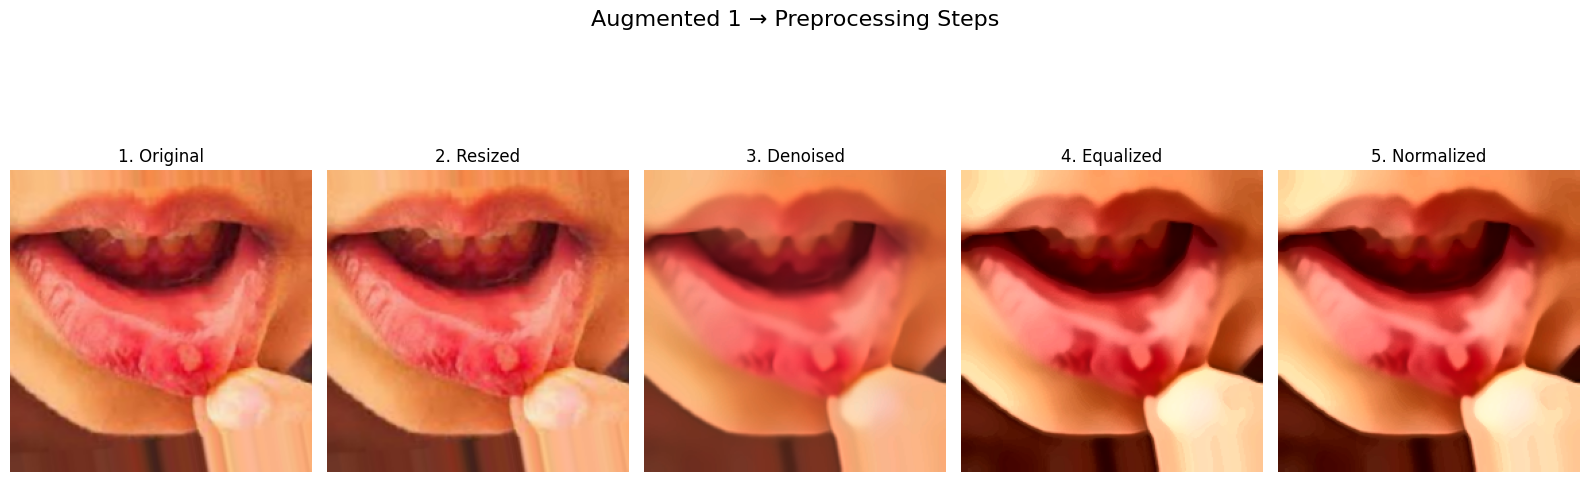

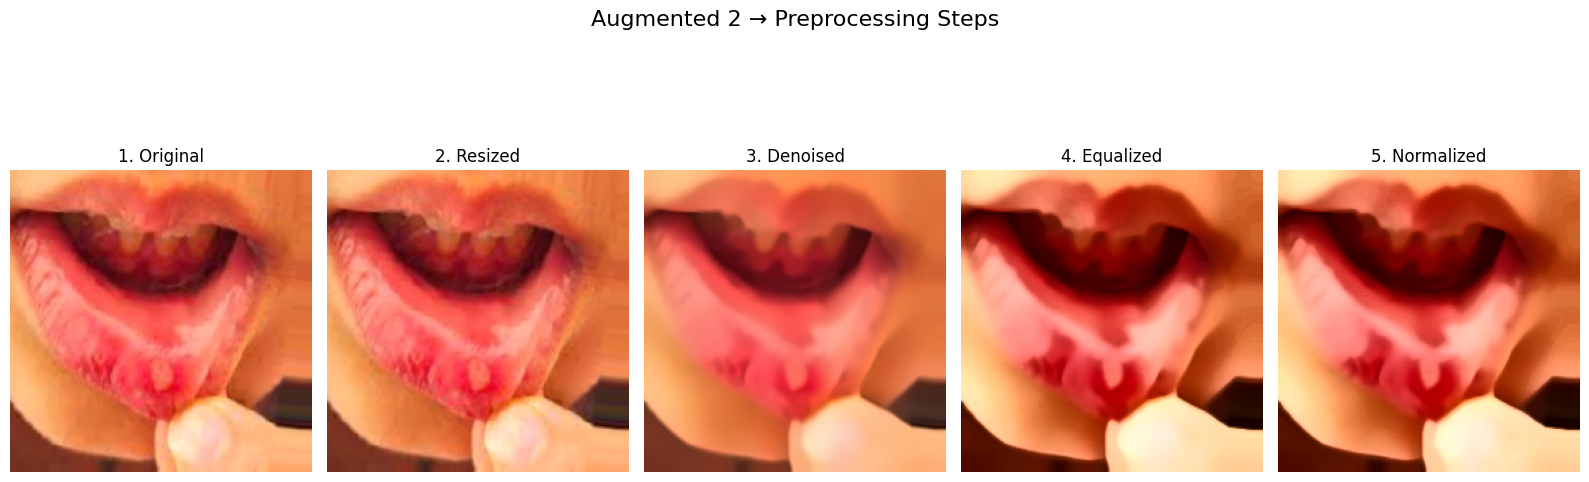

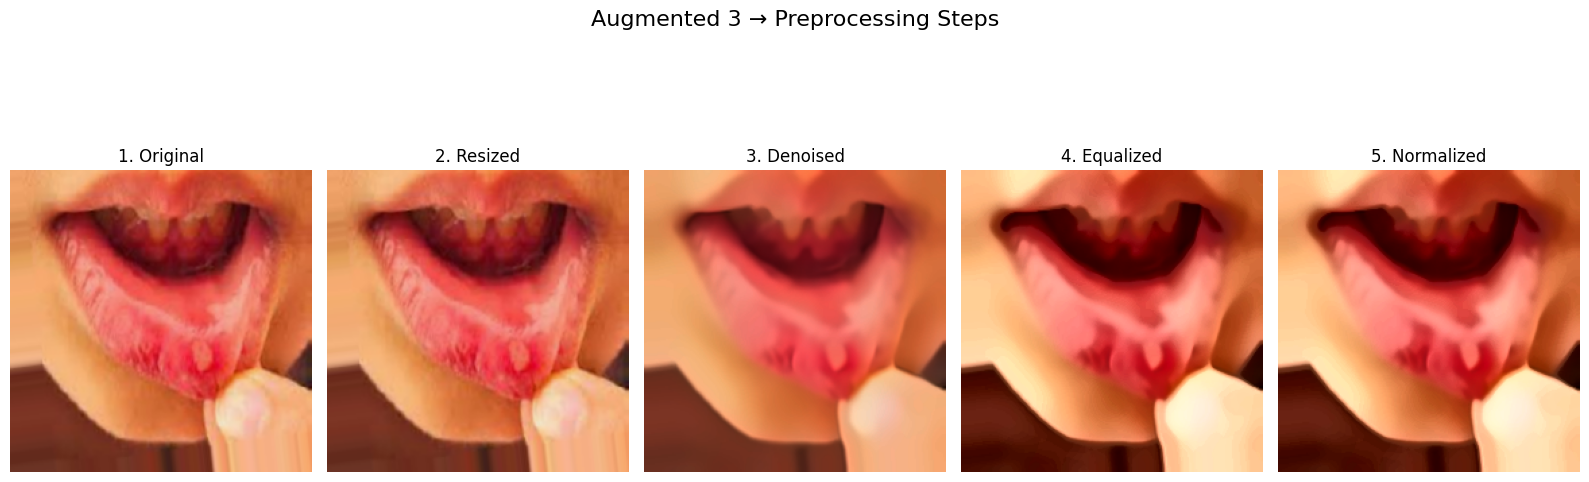

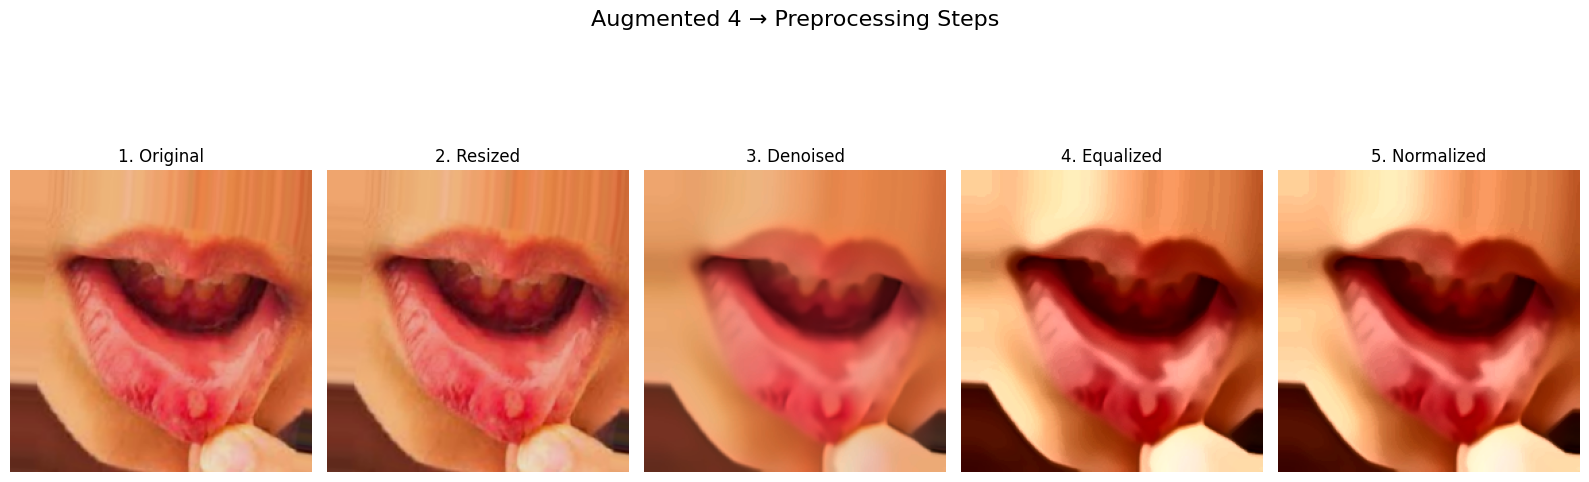

In [8]:
for idx, image in enumerate(all_images):
    steps_dict = preprocess_image_show(image)   

    plt.figure(figsize=(16, 6))
    plt.suptitle(f"{titles[idx]} → Preprocessing Steps", fontsize=16)

    for j, (step_name, disp_img) in enumerate(steps_dict.items()):
        plt.subplot(1, len(steps_dict), j + 1)
        plt.imshow(disp_img)
        plt.title(f"{j+1}. {step_name}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [9]:
y_train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))

print("Calculated Class Weights:", class_weights)


Calculated Class Weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [ ]:
model = Sequential([
    
    Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),


    Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),


    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    BatchNormalization(),


    Conv2D(256, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    BatchNormalization(),

   
    Conv2D(512, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Conv2D(1024, (3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    BatchNormalization(),


    
    GlobalAveragePooling2D(),
    Dense(1024),
    Activation('relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(CLASSES), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751560822.385024    3230 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751560822.385708    3230 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,357,127 (28.07 MB)

 Trainable params: 7,351,047 (28.04 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_sequential_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.2645 - loss: 2.1815
Epoch 1: val_accuracy improved from -inf to 0.14981, saving model to best_sequential_model.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 979ms/step - accuracy: 0.2652 - loss: 2.1789 - val_accuracy: 0.1498 - val_loss: 4.9035
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.3551 - loss: 1.8434
Epoch 2: val_accuracy improved from 0.14981 to 0.16245, saving model to best_sequential_model.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 886ms/step - accuracy: 0.3557 - loss: 1.8421 - val_accuracy: 0.1625 - val_loss: 4.7903
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.4225 - loss: 1.6249
Epoch 3: val_accuracy improved from 0.16245 to 0.24805, saving model to best_sequential_model.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 886ms/step - accuracy: 0.4225 - loss: 1.6252 - val_accuracy: 0.2481 - val_loss: 3.1172
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4528 - loss: 1.5029
Epoch 4: v

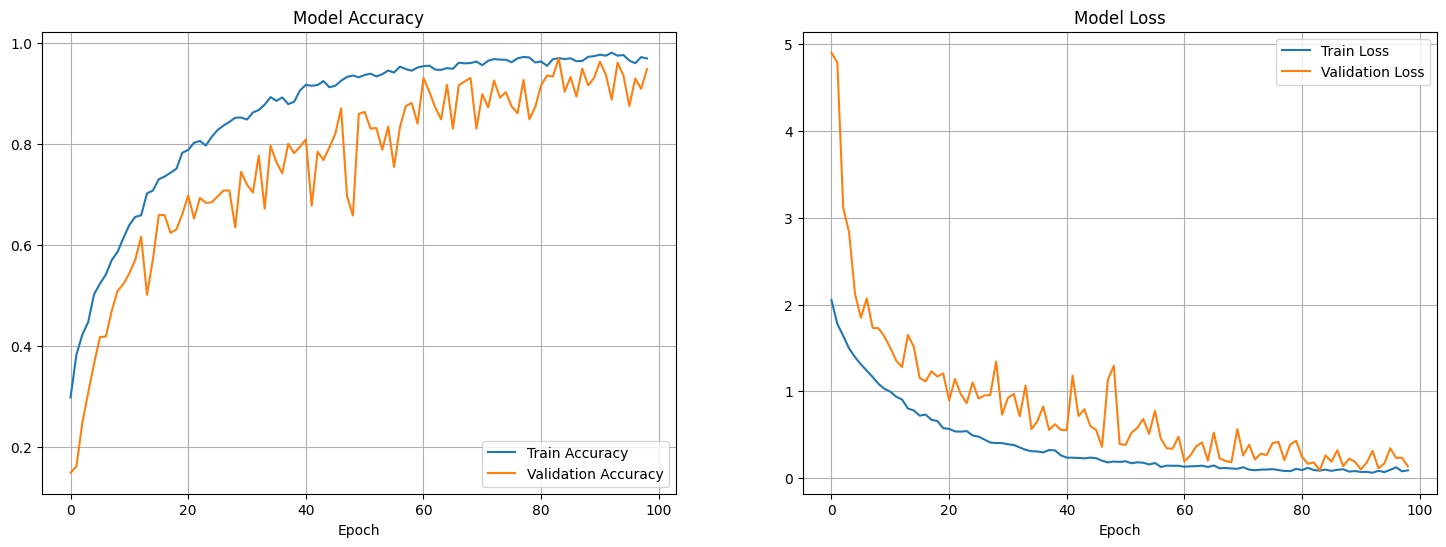

In [16]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    plt.show()

plot_history(history)

In [20]:
model.save_weights("best_scratch_resnet_model.weights.h5")


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step
--- Final Classification Report ---
              precision    recall  f1-score   support

         CaS       1.00      0.91      0.95       160
         CoS       0.98      1.00      0.99       149
         Gum       0.99      0.99      0.99       120
          MC       0.99      0.95      0.97       180
          OC       0.97      0.97      0.97       108
         OLP       0.91      0.99      0.95       180
          OT       0.96      0.99      0.98       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



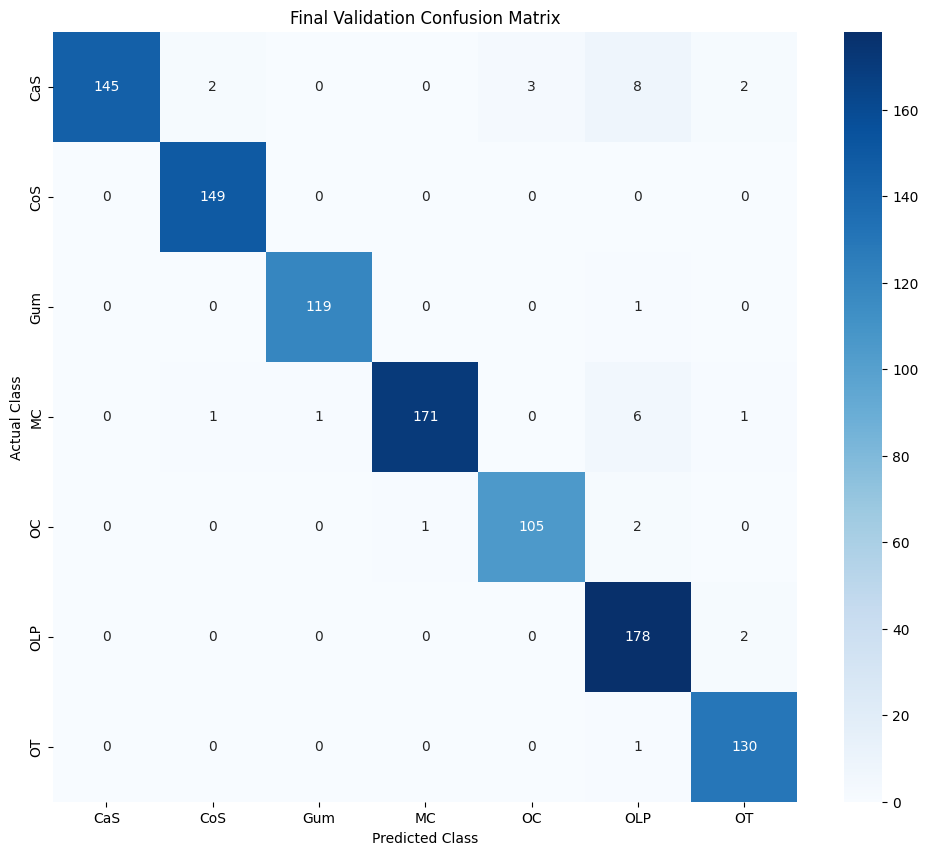

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

model.load_weights("best_scratch_resnet_model.weights.h5")

val_generator.reset()
y_true = val_generator.classes


y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)


if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]


print("--- Final Classification Report ---")
print(classification_report(y_true, y_pred, target_names=CLASSES))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Final Validation Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/teeth-dataset-0/Teeth_Dataset/Testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=False              
)


Found 1508 images belonging to 10 classes.


In [24]:
model.load_weights("best_scratch_resnet_model.weights.h5")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


required_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory="/kaggle/input/teeth-dataset-0/Teeth_Dataset/Testing",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=required_classes 
)


Found 1028 images belonging to 7 classes.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
              precision    recall  f1-score   support

         CaS       0.99      0.89      0.94       160
         CoS       0.99      1.00      0.99       149
         Gum       0.99      0.98      0.99       120
          MC       0.98      0.96      0.97       180
          OC       0.97      0.97      0.97       108
         OLP       0.89      0.98      0.94       180
          OT       0.98      1.00      0.99       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



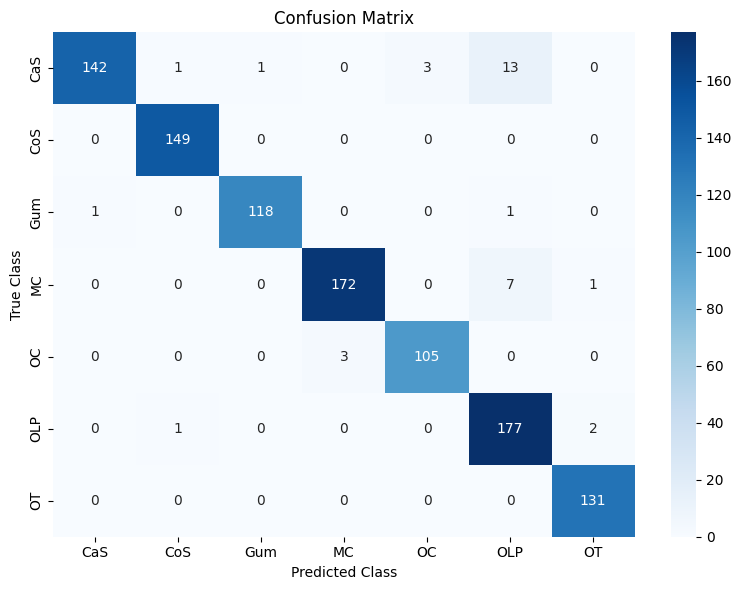

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
labels = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()
